### Задание 1 Сплитование пользователей и проведение А/А-теста.

### Загрузим все необходимые библиотеки, выгрузим датасет из Кликхауса.

In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
#import swifter # Ускорялка метода apply
from scipy import stats # Статистика
%matplotlib inline

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230520'
}

In [3]:
q = """
SELECT uniqExact(user_id)
FROM {db}.feed_actions 
WHERE toDate(time) >= '2023-04-24' and toDate(time) <= '2023-04-30' 
"""


pandahouse.read_clickhouse(q, connection=connection)

,uniqExact(user_id)
0,42585


#### возьмем метод хэширование с солью из лекции и разобьем выборку на группы

In [4]:
def ab_split(id, salt='exp_mess_1', n_groups=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [5]:
q = """
SELECT distinct user_id
FROM {db}.feed_actions 
WHERE toDate(time) >= '2023-04-24' and toDate(time) <= '2023-04-30' 
"""

# Вытащили пользователей
users_df = pandahouse.read_clickhouse(q, connection=connection)

# Сделали группы
users_df['hash_group'] = users_df.user_id.apply(ab_split)

In [6]:
users_df.groupby('hash_group').user_id.nunique().reset_index()

,hash_group,user_id
0,0,8725
1,1,8354
2,2,8516
3,3,8433
4,4,8557


In [7]:
# выгрузим из Кликхауса необходимые данные
q = """
    SELECT 
            exp_group,
            user_id,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes / views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-04-24' and '2023-04-30'
            and exp_group in (2, 3)
    GROUP BY exp_group, user_id
    
"""

In [8]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [9]:
# Загрузим датасет
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [10]:
#Убедимся, что юзеров одинаковое +- количество в группах
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


In [11]:
#увеличим размер в сиборне
sns.set(rc={'figure.figsize':(11.7,8.27)})

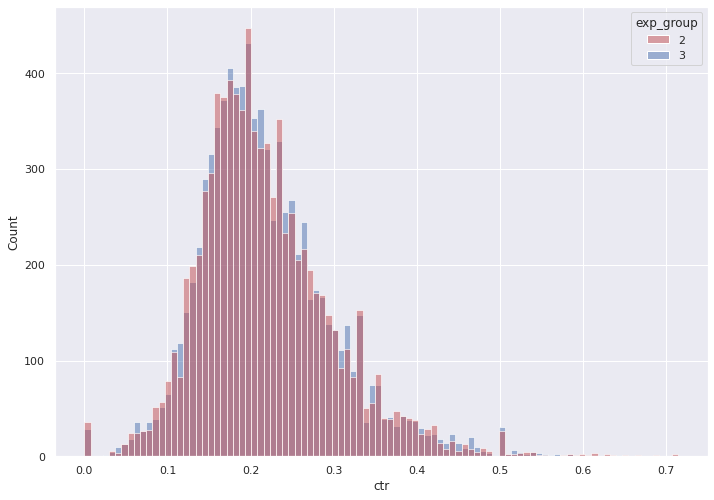

In [12]:
# отрисуем график, чтобы убедиться наглядно 
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [13]:
# проведем ttest
result = stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)
print('p-value:', result.pvalue)
print('statistic:', result.statistic)

p-value: 0.45969873156476293
statistic: -0.7393597924958364


Итак, что нужно сделать: у нас есть данные АА-теста с '2023-04-24' по '2023-04-30'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

Построить гистограмму распределения получившихся 10000 p-values.

Посчитать, какой процент p values оказался меньше либо равен 0.05

Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

Пришлите ссылку на merge request c проведенным анализом.

In [14]:
#Сформируем подвыборки по 500 юзеров, зададим количество тестов 10000, создадим переменную для хранения  p-values

n_users = 500

n_split = 10000

p_values = list()

In [15]:
# Проведем сплитование n_split раз

for _ in range(n_split):
    df1 = df.sample(n_users, replace=False) 
    result_split = stats.ttest_ind(df1[df1.exp_group == 2].ctr,
                    df1[df1.exp_group == 3].ctr,
                    equal_var=False)
    #print('p-value:', result_split.pvalue)
    #print('statistic:', result_split.statistic)
    # Добавляем p-value в список
    p_values.append(result_split[1])

In [16]:
len(p_values)

10000

<AxesSubplot:ylabel='Count'>

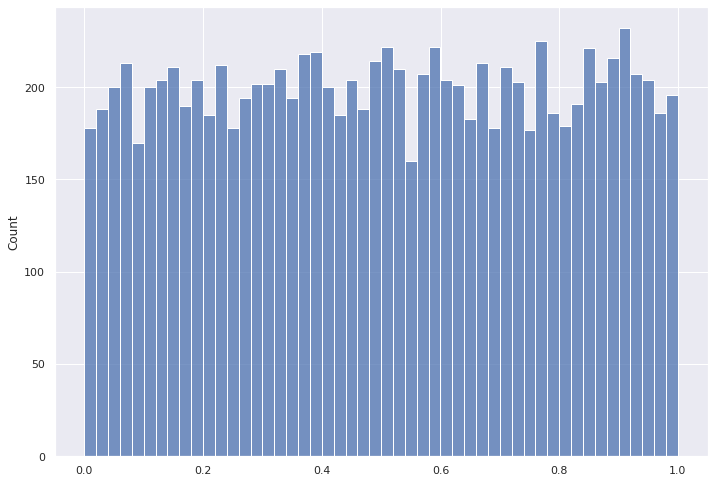

In [17]:
# отрисуем гистограмму полученных значений p-value
sns.histplot(p_values, kde=False, bins = 50)

In [18]:
# теперь посчитаем, какой процент p-values оказался меньше либо равен 0.05
value = 0
for i in p_values:
    if i <= 0.05:
       value += 1
t=value*100/n_split 

In [19]:
t

4.65

##  Вывод по проведенной работе в домашнем задании: 

Сплитование можно считать удовлетворительным, так как статистически значимых отклонений не больше 5%, то есть ложноположительных